In [17]:
import json
with open('heldout_predictions.json', 'r') as f:
    yolo_predictions = json.load(f)

In [18]:
# Explore the structure of yolo_predictions
print(f"Number of predictions: {len(yolo_predictions)}")
print(f"\nSample prediction structure:")
if yolo_predictions:
    print(json.dumps(yolo_predictions[0], indent=2))

Number of predictions: 7594

Sample prediction structure:
{
  "image": "498840129.jpg",
  "detections": [
    {
      "class_id": 2,
      "class_name": "1",
      "confidence": 0.9420477151870728,
      "bbox": [
        0.14887288212776184,
        0.61411452293396,
        0.04441337659955025,
        0.14963658154010773
      ]
    },
    {
      "class_id": 11,
      "class_name": "9",
      "confidence": 0.939793050289154,
      "bbox": [
        0.294821172952652,
        0.6154964566230774,
        0.07656688988208771,
        0.1469368040561676
      ]
    },
    {
      "class_id": 3,
      "class_name": "2",
      "confidence": 0.9367019534111023,
      "bbox": [
        0.210369274020195,
        0.6209737658500671,
        0.07489123195409775,
        0.15310326218605042
      ]
    },
    {
      "class_id": 28,
      "class_name": "P",
      "confidence": 0.32791227102279663,
      "bbox": [
        0.15002712607383728,
        0.3754190504550934,
        0.0873125046491

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Extract all confidence scores from predictions
all_confidences = []
predictions_per_image = []

for pred in yolo_predictions:
    if 'detections' in pred and pred['detections']:
        confidences = [p['confidence'] for p in pred['detections']]
        all_confidences.extend(confidences)
        predictions_per_image.append(len(confidences))
    else:
        predictions_per_image.append(0)

# Calculate statistics
if all_confidences:
    avg_confidence = np.mean(all_confidences)
    median_confidence = np.median(all_confidences)
    std_confidence = np.std(all_confidences)
    min_confidence = np.min(all_confidences)
    max_confidence = np.max(all_confidences)
    
    print("=" * 50)
    print("CONFIDENCE STATISTICS")
    print("=" * 50)
    print(f"Total predictions: {len(all_confidences)}")
    print(f"Average confidence: {avg_confidence:.4f}")
    print(f"Median confidence: {median_confidence:.4f}")
    print(f"Std deviation: {std_confidence:.4f}")
    print(f"Min confidence: {min_confidence:.4f}")
    print(f"Max confidence: {max_confidence:.4f}")
    print(f"\nAverage predictions per image: {np.mean(predictions_per_image):.2f}")
    print(f"Images with no predictions: {predictions_per_image.count(0)}")
else:
    print("No predictions found in the data")

CONFIDENCE STATISTICS
Total predictions: 43427
Average confidence: 0.6623
Median confidence: 0.7581
Std deviation: 0.2834
Min confidence: 0.1500
Max confidence: 0.9986

Average predictions per image: 5.72
Images with no predictions: 106


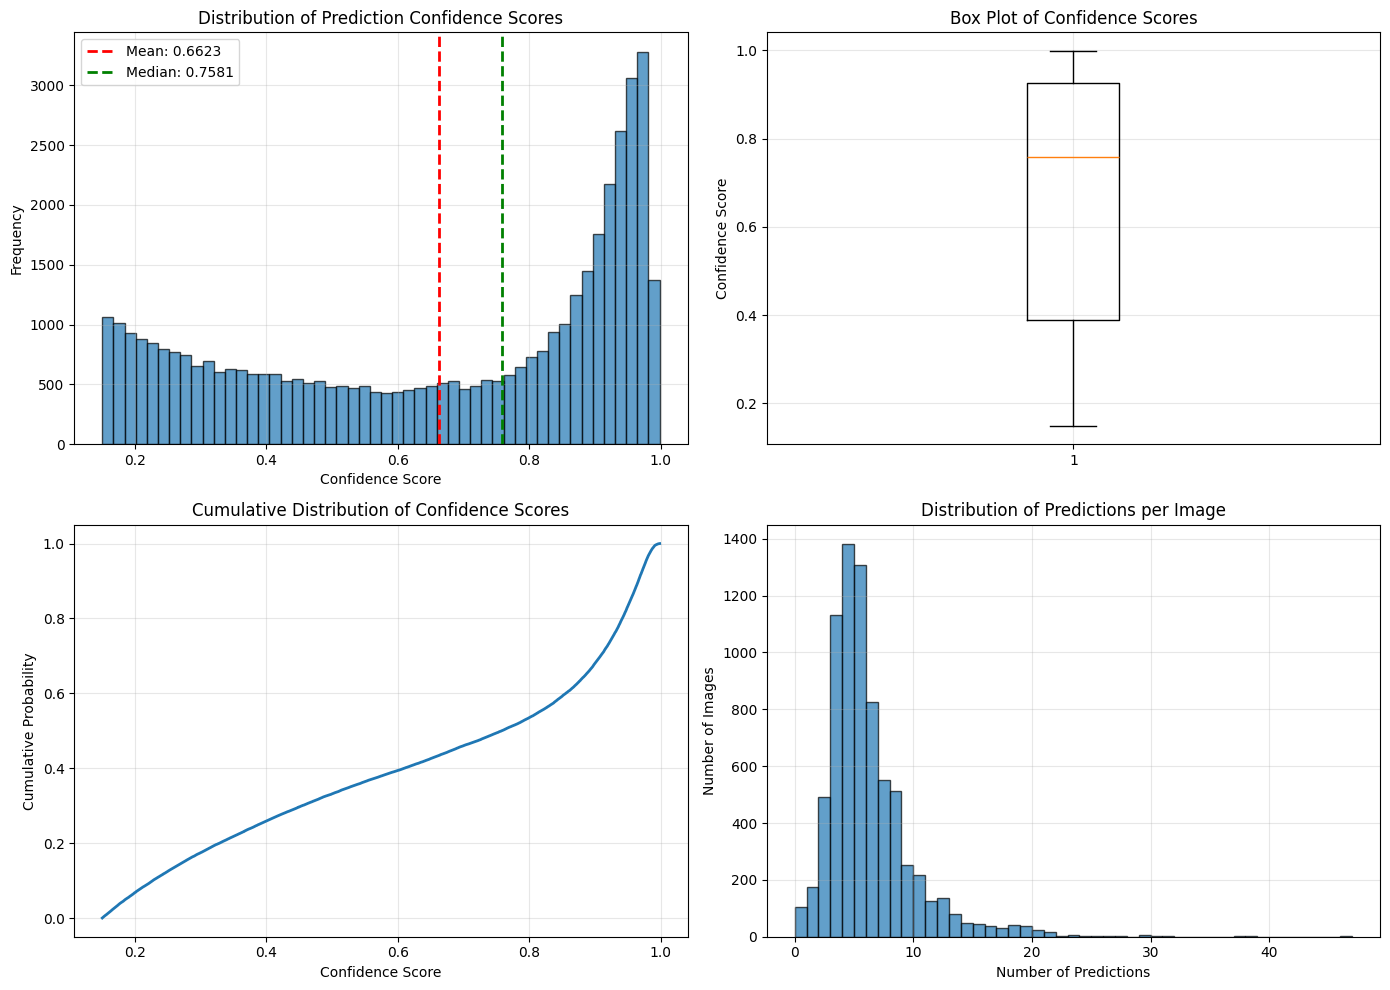


CONFIDENCE THRESHOLD ANALYSIS
Predictions with confidence >= 0.3: 35852 (82.56%)
Predictions with confidence >= 0.5: 29027 (66.84%)
Predictions with confidence >= 0.7: 23442 (53.98%)
Predictions with confidence >= 0.9: 13916 (32.04%)


In [20]:
# Visualize confidence distribution
if all_confidences:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Histogram
    axes[0, 0].hist(all_confidences, bins=50, edgecolor='black', alpha=0.7)
    axes[0, 0].axvline(avg_confidence, color='red', linestyle='--', linewidth=2, label=f'Mean: {avg_confidence:.4f}')
    axes[0, 0].axvline(median_confidence, color='green', linestyle='--', linewidth=2, label=f'Median: {median_confidence:.4f}')
    axes[0, 0].set_xlabel('Confidence Score')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Distribution of Prediction Confidence Scores')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Box plot
    axes[0, 1].boxplot(all_confidences, vert=True)
    axes[0, 1].set_ylabel('Confidence Score')
    axes[0, 1].set_title('Box Plot of Confidence Scores')
    axes[0, 1].grid(True, alpha=0.3)
    
    # CDF
    sorted_conf = np.sort(all_confidences)
    cdf = np.arange(1, len(sorted_conf) + 1) / len(sorted_conf)
    axes[1, 0].plot(sorted_conf, cdf, linewidth=2)
    axes[1, 0].set_xlabel('Confidence Score')
    axes[1, 0].set_ylabel('Cumulative Probability')
    axes[1, 0].set_title('Cumulative Distribution of Confidence Scores')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Predictions per image
    axes[1, 1].hist(predictions_per_image, bins=max(predictions_per_image) if predictions_per_image else 1, 
                    edgecolor='black', alpha=0.7)
    axes[1, 1].set_xlabel('Number of Predictions')
    axes[1, 1].set_ylabel('Number of Images')
    axes[1, 1].set_title('Distribution of Predictions per Image')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Confidence thresholds analysis
    print("\n" + "=" * 50)
    print("CONFIDENCE THRESHOLD ANALYSIS")
    print("=" * 50)
    thresholds = [0.3, 0.5, 0.7, 0.9]
    for threshold in thresholds:
        count = sum(1 for c in all_confidences if c >= threshold)
        percentage = (count / len(all_confidences)) * 100
        print(f"Predictions with confidence >= {threshold}: {count} ({percentage:.2f}%)")

## Analyze remaining overlaps in predictions (IoU < 0.7)

Check how many box pairs have IoU between 0.5 and 0.7

In [21]:
def calculate_iou(box1, box2):
    """Calculate IoU between two boxes in xywhn format"""
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    
    # Convert to corner coordinates
    x1_min, y1_min = x1 - w1/2, y1 - h1/2
    x1_max, y1_max = x1 + w1/2, y1 + h1/2
    x2_min, y2_min = x2 - w2/2, y2 - h2/2
    x2_max, y2_max = x2 + w2/2, y2 + h2/2
    
    # Calculate intersection
    inter_xmin = max(x1_min, x2_min)
    inter_ymin = max(y1_min, y2_min)
    inter_xmax = min(x1_max, x2_max)
    inter_ymax = min(y1_max, y2_max)
    
    inter_w = max(0, inter_xmax - inter_xmin)
    inter_h = max(0, inter_ymax - inter_ymin)
    inter_area = inter_w * inter_h
    
    # Calculate union
    box1_area = w1 * h1
    box2_area = w2 * h2
    union_area = box1_area + box2_area - inter_area
    
    return inter_area / union_area if union_area > 0 else 0

# Analyze overlaps in the existing predictions
overlap_stats = {
    'total_pairs': 0,
    'iou_0_to_0.5': 0,
    'iou_0.5_to_0.7': 0,
    'images_with_overlap_0.5_to_0.7': 0
}

images_with_medium_overlap = []

for pred in yolo_predictions:
    detections = pred.get('detections', [])
    if len(detections) < 2:
        continue
    
    has_medium_overlap = False
    
    # Check all pairs of boxes
    for i in range(len(detections)):
        for j in range(i + 1, len(detections)):
            box1 = detections[i]['bbox']
            box2 = detections[j]['bbox']
            iou = calculate_iou(box1, box2)
            
            overlap_stats['total_pairs'] += 1
            
            if iou < 0.5:
                overlap_stats['iou_0_to_0.5'] += 1
            elif 0.5 <= iou < 0.7:
                overlap_stats['iou_0.5_to_0.7'] += 1
                has_medium_overlap = True
    
    if has_medium_overlap:
        overlap_stats['images_with_overlap_0.5_to_0.7'] += 1
        images_with_medium_overlap.append({
            'image': pred['image'],
            'num_detections': len(detections)
        })

print("=" * 60)
print("OVERLAP ANALYSIS (Remaining after YOLO NMS with iou=0.7)")
print("=" * 60)
print(f"Total box pairs analyzed: {overlap_stats['total_pairs']}")
print(f"\nBox pairs with IoU < 0.5: {overlap_stats['iou_0_to_0.5']} "
      f"({overlap_stats['iou_0_to_0.5']/max(overlap_stats['total_pairs'], 1)*100:.2f}%)")
print(f"Box pairs with 0.5 <= IoU < 0.7: {overlap_stats['iou_0.5_to_0.7']} "
      f"({overlap_stats['iou_0.5_to_0.7']/max(overlap_stats['total_pairs'], 1)*100:.2f}%)")
print(f"\nImages with at least one overlap in [0.5, 0.7): {overlap_stats['images_with_overlap_0.5_to_0.7']}")
print(f"Percentage of images: {overlap_stats['images_with_overlap_0.5_to_0.7']/len(yolo_predictions)*100:.2f}%")

if images_with_medium_overlap:
    print(f"\nSample images with medium overlap (0.5-0.7):")
    for img in images_with_medium_overlap[:5]:
        print(f"  {img['image']} ({img['num_detections']} detections)")

OVERLAP ANALYSIS (Remaining after YOLO NMS with iou=0.7)
Total box pairs analyzed: 152610

Box pairs with IoU < 0.5: 152610 (100.00%)
Box pairs with 0.5 <= IoU < 0.7: 0 (0.00%)

Images with at least one overlap in [0.5, 0.7): 0
Percentage of images: 0.00%


In [22]:
import numpy as np
import pandas as pd

# Collect all IoU values
all_ious = []

for pred in yolo_predictions:
    detections = pred.get('detections', [])
    if len(detections) < 2:
        continue
    
    # Calculate IoU for all pairs
    for i in range(len(detections)):
        for j in range(i + 1, len(detections)):
            box1 = detections[i]['bbox']
            box2 = detections[j]['bbox']
            iou = calculate_iou(box1, box2)
            all_ious.append(iou)

# Create frequency table with bins of 0.1
bins = np.arange(0, 1.1, 0.1)
frequency_data = []

for i in range(len(bins)-1):
    count = np.sum((all_ious >= bins[i]) & (all_ious < bins[i+1]))
    percentage = count / len(all_ious) * 100 if len(all_ious) > 0 else 0
    frequency_data.append({
        'IoU Range': f'[{bins[i]:.1f}, {bins[i+1]:.1f})',
        'Frequency': count,
        'Percentage': f'{percentage:.2f}%'
    })

# Create DataFrame
freq_table = pd.DataFrame(frequency_data)

print("=" * 60)
print("IoU FREQUENCY TABLE")
print("=" * 60)
print(f"Total box pairs analyzed: {len(all_ious)}\n")
print(freq_table.to_string(index=False))

print(f"\n{'=' * 60}")
print("SUMMARY STATISTICS")
print("=" * 60)
if len(all_ious) > 0:
    print(f"Mean IoU: {np.mean(all_ious):.4f}")
    print(f"Median IoU: {np.median(all_ious):.4f}")
    print(f"Max IoU: {np.max(all_ious):.4f}")
    
else:
    print("No box pairs found")

IoU FREQUENCY TABLE
Total box pairs analyzed: 152610

 IoU Range  Frequency Percentage
[0.0, 0.1)     151397     99.21%
[0.1, 0.2)        420      0.28%
[0.2, 0.3)        200      0.13%
[0.3, 0.4)        232      0.15%
[0.4, 0.5)        361      0.24%
[0.5, 0.6)          0      0.00%
[0.6, 0.7)          0      0.00%
[0.7, 0.8)          0      0.00%
[0.8, 0.9)          0      0.00%
[0.9, 1.0)          0      0.00%

SUMMARY STATISTICS
Mean IoU: 0.0032
Median IoU: 0.0000
Max IoU: 0.5000
